# Imports

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

import warnings
warnings.filterwarnings('ignore')

# Download data

In [2]:
# import requests

# # download dataset by chunks
# url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

# req = requests.get(url, stream=True)

# with open('data_kion.zip', "wb") as fd:
#     total_size_in_bytes = int(req.headers.get('Content-Length', 0))
#     progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
#     for chunk in req.iter_content(chunk_size=2 ** 20):
#         progress_bar.update(len(chunk))
#         fd.write(chunk)

In [3]:
# # Распаковываем архив из 3 файлов
# import zipfile
 
# with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [4]:
interactions = pd.read_csv('../data/interactions_df.csv')
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


# 1 Дизайн теста

## 1.1 Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [5]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique()}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique()}")

Уникальных юзеров в interactions: 962179
Уникальных айтемов в interactions: 15706


In [6]:
interactions['last_watch_dt'].max()

datetime.date(2021, 8, 22)

In [7]:
interactions['last_watch_dt'].max() - datetime.timedelta(days=14)

datetime.date(2021, 8, 8)

In [8]:
# выделим данные за 2 последние недели
two_weeks = interactions[interactions['last_watch_dt'] >= interactions['last_watch_dt'].max() - datetime.timedelta(days=14)]
two_weeks = two_weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [9]:
two_weeks.shape

(279129, 2)

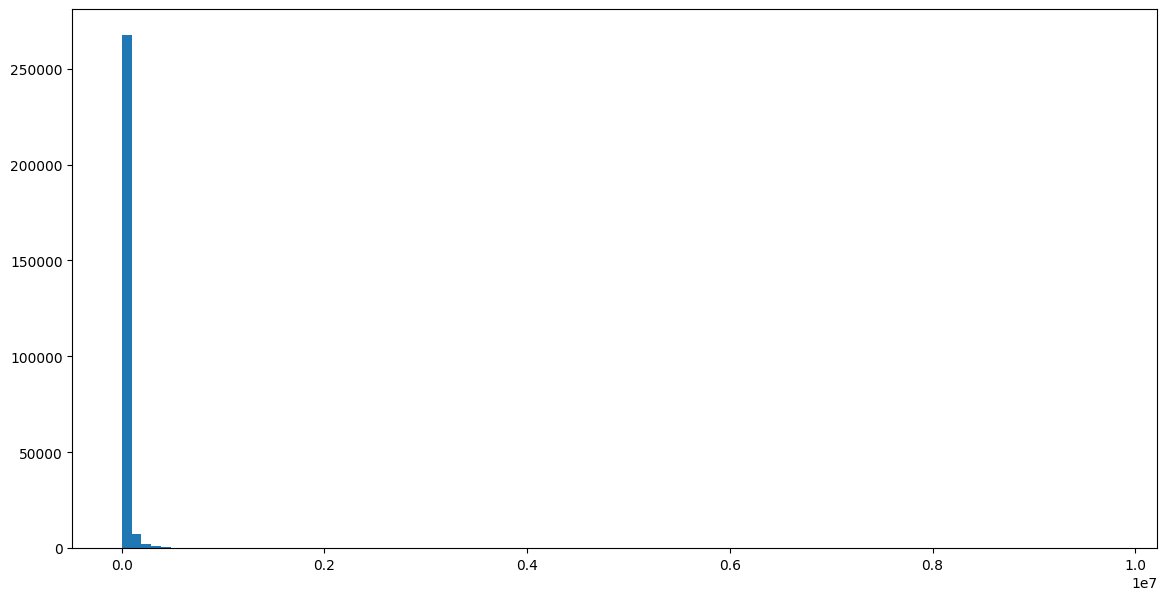

In [10]:
two_weeks['total_dur'].hist(bins=100, figsize=(14,7))
plt.grid(False)

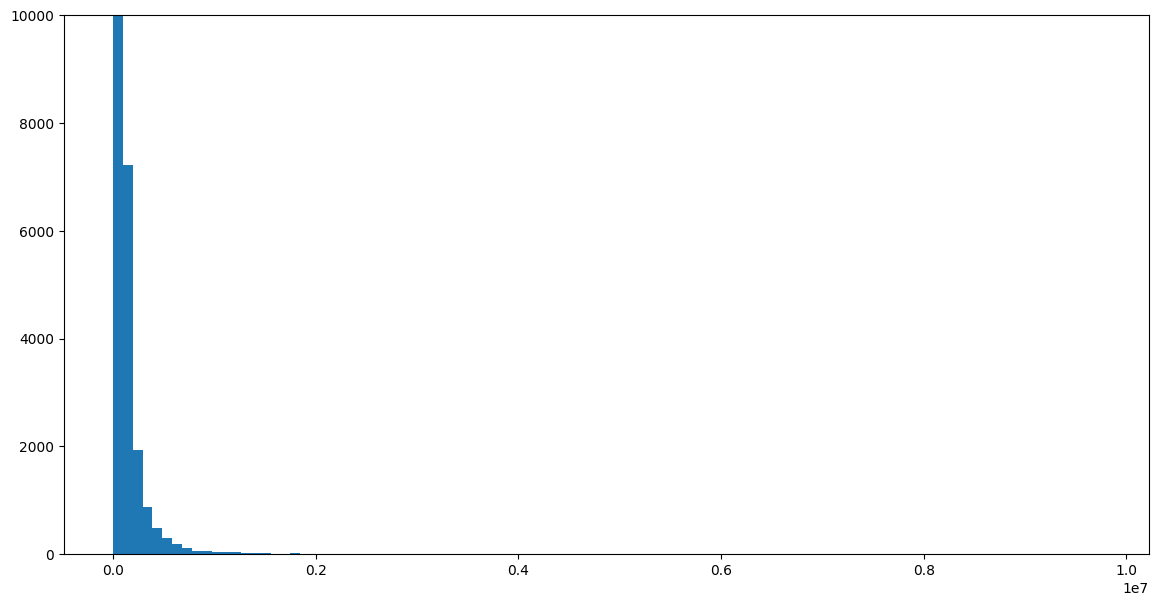

In [11]:
two_weeks['total_dur'].hist(bins=100, figsize=(14,7))
plt.ylim([0, 10000])
plt.grid(False)

В задании ничего не сказано про препроцессинг данных (отсечение выбросов и т.п.), поэтому делать этого не будем. При препроцессинге результаты могли бы быть иными

<Axes: >

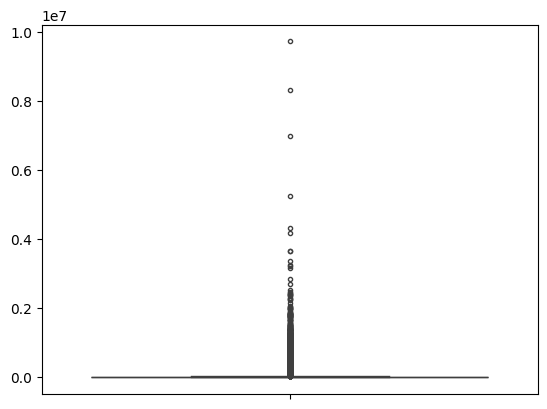

In [12]:
sns.boxplot(two_weeks['total_dur'].values, fliersize=3)

In [13]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [14]:
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt is None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [15]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

```text
significance: 5.0% - на семинаре
```

## 1.2 Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

In [16]:
correctness = []
values = []

for i in tqdm(range(1000)):
    
    splitted_groups = groups_splitter(two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = splitted_groups[(splitted_groups['group'] == 'A')]['total_dur']
    vec_b = splitted_groups[(splitted_groups['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)

alpha = test_correctness[1]/(test_correctness[1] + test_correctness[0])*100
    
print(f'alpha = {alpha}%')

100%|██████████| 1000/1000 [1:22:40<00:00,  4.96s/it]

alpha = 5.1%


На семинаре (за 1 неделю) было 5%

По криетрию Колмогорова-Смирнова проверим, что распределение p_values является равномерным

In [17]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

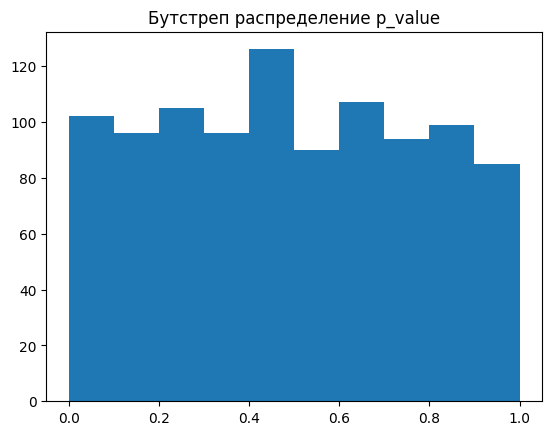

In [18]:
plt.hist(p_values, bins=10);
plt.title(f"Бутстреп распределение p_value")

In [19]:
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.22129596683580788 - p_values равномерное распределение


## 1.3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

In [20]:
def calculate_power(effect, verbose=False):
    powers = []
    values = []

    for i in tqdm(range(1000)):
        splitted_groups = groups_splitter(
            two_weeks.copy(),
            columns=['user_id', 'total_dur', 'group'],
            user_salt=salt_generator()
        ).drop_duplicates()

        vec_a = splitted_groups[(splitted_groups['group'] == 'A')]['total_dur']
        vec_b = splitted_groups[(splitted_groups['group'] == 'B')]['total_dur']
        vec_b = vec_b * (1+effect)

        # bootstrap
        sample_a_mean = calc_bootstrap_mean(vec_a) # на бутстрэпе считаем средние для вектора
        sample_b_mean = calc_bootstrap_mean(vec_b)
        values.append(sample_a_mean - sample_b_mean)

        left_side, right_side = np.percentile(
            sample_a_mean - sample_b_mean,
            [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
        ) # считаем 95% доверительный интервал для разницы средних

        powers.append(not left_side <= 0 <= right_side)

        test_powers = collections.Counter(powers)

    power = test_powers[1]/(test_powers[1] + test_powers[0])*100

    if verbose:
        print(f'\neffect: {effect}, power: {power}%')

    return power

In [21]:
def calculate_beta(effect, verbose=False):
    betas = []
    values = []

    for i in tqdm(range(1000)):
        splitted_groups = groups_splitter(
            two_weeks.copy(),
            columns=['user_id', 'total_dur', 'group'],
            user_salt=salt_generator()
        ).drop_duplicates()

        vec_a = splitted_groups[(splitted_groups['group'] == 'A')]['total_dur']
        vec_b = splitted_groups[(splitted_groups['group'] == 'B')]['total_dur']
        vec_b = vec_b * (1+effect)

        # bootstrap
        sample_a_mean = calc_bootstrap_mean(vec_a) # на бутстрэпе считаем средние для вектора
        sample_b_mean = calc_bootstrap_mean(vec_b)
        values.append(sample_a_mean - sample_b_mean)

        left_side, right_side = np.percentile(
            sample_a_mean - sample_b_mean,
            [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
        ) # считаем 95% доверительный интервал для разницы средних

        betas.append(left_side <= 0 <= right_side)

        test_betas = collections.Counter(betas)

    beta = test_betas[1]/(test_betas[1] + test_betas[0])*100

    if verbose:
        print(f'\neffect: {effect}, beta: {beta}%')

    return beta

In [22]:
# Уровни эффекта: 1%, 3%, 5%
effects = [0.01, 0.03, 0.05]

# Расчет мощности для каждого уровня эффекта
betas = [calculate_beta(effect) for effect in effects]
powers = [100-beta for beta in betas]

# Вывод результатов
for effect, beta, power in zip(effects, betas, powers):
    print('\n')
    print(f'Effect: {effect * 100}%')
    print(f'beta: {beta}%')
    print(f'power: {power}%')

100%|██████████| 1000/1000 [1:21:50<00:00,  4.91s/it]



Effect: 1.0%
beta: 88.3%
power: 11.700000000000003%


Effect: 3.0%
beta: 36.8%
power: 63.2%


Effect: 5.0%
beta: 3.3000000000000003%
power: 96.7%


## 1.4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

Посчитаем mde по формуле, но будем помнить, что для бутсрепа она не подходит.  
Ниже также попробуем линейно экстраполировать mde исходя из вычислений beta для разных effects

In [23]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [24]:
formula_mdes = []
print('Значения mde при заданных alpha и beta:')
for beta in betas:
    mde = get_mde(splitted_groups.total_dur, alpha=alpha/100, beta=beta/100)
    formula_mdes.append(mde)
    print()
    print(f'beta={beta}%')
    print(f'alpha={alpha}%')
    print(f'mde (formula)={mde}%')
    
print('\n\n')
print(f'mde (formula)={get_mde(splitted_groups.total_dur, alpha=alpha/100, beta=0.8)} при alpha={alpha}%, beta={80}%')

Значения mde при заданных alpha и beta:

beta=88.3%
alpha=5.1%
mde (formula)=0.4904262154216033%

beta=36.8%
alpha=5.1%
mde (formula)=1.4742092774614861%

beta=3.3000000000000003%
alpha=5.1%
mde (formula)=2.441241692529611%



mde (formula)=0.7149081715058045 при alpha=5.1%, beta=80%


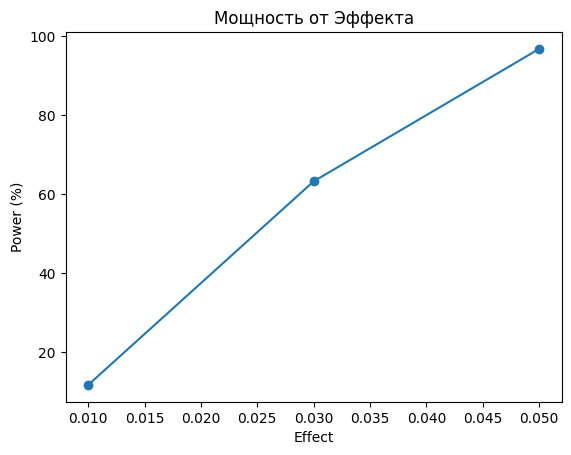

In [25]:
plt.plot(effects, powers, marker='o')
plt.xlabel('Effect')
plt.ylabel('Power (%)')
plt.title('Мощность от Эффекта')
plt.show()

In [26]:
# y=kx+b - регрессия между 3% и 5% 
k = (powers[2] - powers[1]) / (effects[2] - effects[1])
b = powers[2] - effects[2] * k

# зафиксируем beta=20% => power=80% 

power = 80

mde = (power - b) / k
print(f'MDE = {mde:0.3%}')

MDE = 4.003%


На самом деле, неизвестно, является ли найденный по регрессии эффект минимальным, но прямой формулы для нашего случая всё равно нет

Кажется, что значения при регрессионном подходе больше похожи на правду

# 2 A/B тест

## 2.1 Представим что у нас прошел тест, используем те же самые данные за 2 недели

## 2.2 Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

In [27]:
interactions.loc[interactions["total_dur"] < 500,"total_dur"] = 0

In [28]:
interactions.sort_values(["total_dur"]).head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3410681,797608,10886,2021-07-13,0,3.0
1932470,330119,7025,2021-07-27,0,1.0
2632292,511161,6003,2021-08-11,0,4.0
3178082,792786,7626,2021-07-20,0,1.0
2801782,235733,12401,2021-06-08,0,2.0


## 2.3 Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

## 2.4 Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)


In [29]:
splitted_df = groups_splitter(two_weeks.copy(),columns=['user_id', 'total_dur', 'group'],user_salt="kiontestmodel20210805").drop_duplicates()

vec_a = splitted_df[(splitted_df['group'] == 'A')]['total_dur']
vec_b = splitted_df[(splitted_df['group'] == 'B')]['total_dur'].to_frame()
vec_b.loc[
    vec_b.sort_values(["total_dur"], ascending=False).head(int(vec_b.shape[0] * 0.1)).index,
    ["total_dur"]
] *= 1.025
vec_b["total_dur"] = vec_b["total_dur"].astype(int)
vec_b = vec_b['total_dur']

In [30]:
import plotly.express as px

Пример распределений средних в обеих группах:

In [31]:
sample_a_mean = calc_bootstrap_mean(vec_a)
sample_b_mean = calc_bootstrap_mean(vec_b)
px.histogram({'Group A': sample_a_mean, 'Group B': sample_b_mean}, x=['Group A', 'Group B'], barmode='overlay').show()

## 2.5 Посчитайте результат такого теста и сделайте выводы (2 балла)

In [32]:
proved_differences = []
values = []
for i in tqdm(range(1000)):
    
    sample_a_mean = calc_bootstrap_mean(vec_a)
    sample_b_mean = calc_bootstrap_mean(vec_b)
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    
    proved_differences.append(not left_side <= 0 <= right_side)
    
    counter = collections.Counter(proved_differences)
proved_pct = (counter[1]/(counter[1] + counter[0])*100)
print(f'Процент статистически значимых запусков = {proved_pct}%')
print(f'В {proved_pct}% случаев группы были статистически значимо различимы')

100%|██████████| 1000/1000 [1:07:19<00:00,  4.04s/it]

Процент статистически значимых запусков = 0.0%
В 0.0% случаев группы были статистически значимо различимы


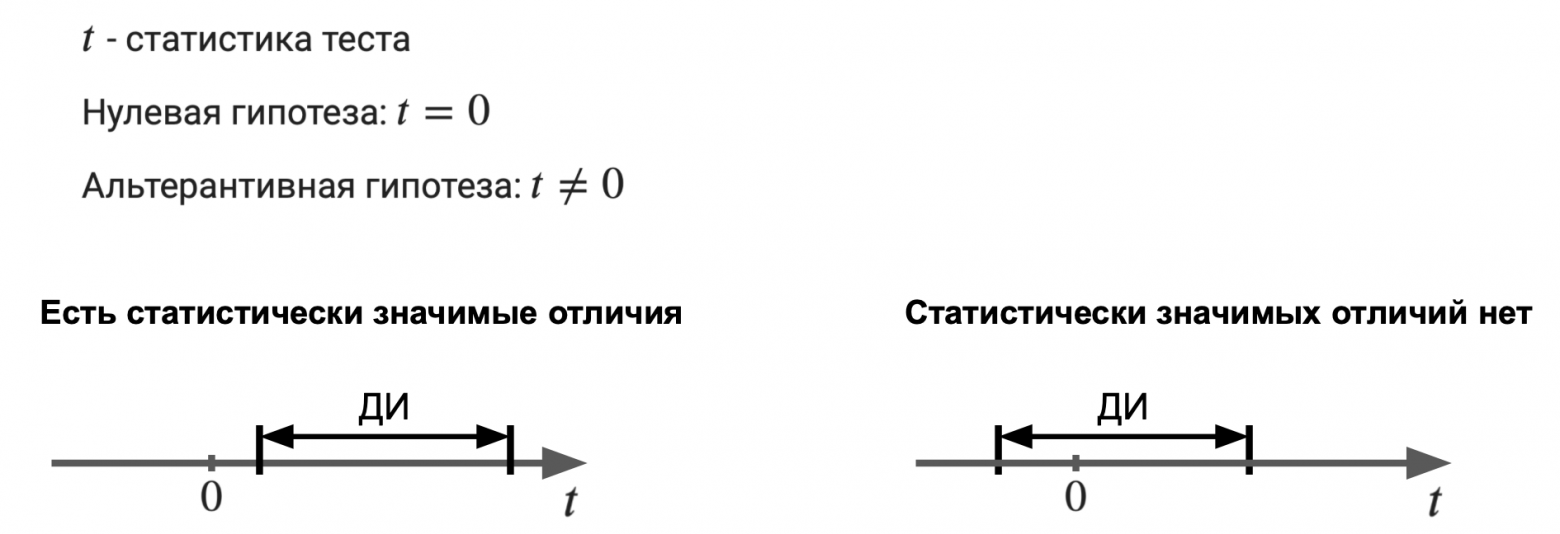

Таким образом, тест не выявил эффект в группе B  

Это было ожидаемо, т.к. при регрессинном вычислении MDE = 4.003%, а докинули мы только 2.5%, причем для 10% пользователей  
Если попробовать считать MDE по формуле, то при  при alpha=5.1%, beta=80% mde будет 0.715%, и различия должны были наблюдаться  
Таким образом, приходим к выводу, что расчёт MDE по формуле для t-test или z-test не работает для bootstrap

## Доп
Т.к. регрессионный MDE у нас около 4%, попробуем докинуть эффект в 4.2% также на 10% пользователей

In [71]:
splitted_df = groups_splitter(two_weeks.copy(),columns=['user_id', 'total_dur', 'group'],user_salt="kiontestmodel20210805").drop_duplicates()

vec_a = splitted_df[(splitted_df['group'] == 'A')]['total_dur']
vec_b = splitted_df[(splitted_df['group'] == 'B')]['total_dur'].to_frame()
vec_b.loc[
    vec_b.sort_values(["total_dur"], ascending=False).head(int(vec_b.shape[0] * 0.1)).index,
    ["total_dur"]
] *= 1.042
vec_b["total_dur"] = vec_b["total_dur"].astype(int)
vec_b = vec_b['total_dur']

In [72]:
sample_a_mean = calc_bootstrap_mean(vec_a)
sample_b_mean = calc_bootstrap_mean(vec_b)
px.histogram({'Group A': sample_a_mean, 'Group B': sample_b_mean}, x=['Group A', 'Group B'], barmode='overlay').show()

In [75]:
proved_differences = []
for i in tqdm(range(100)):
    sample_a_mean = calc_bootstrap_mean(vec_a)
    sample_b_mean = calc_bootstrap_mean(vec_b)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    proved_differences.append(not left_side <= 0 <= right_side)

    counter = collections.Counter(proved_differences)
    proved_pct = (counter[1]/(counter[1] + counter[0])*100)

100%|██████████| 100/100 [06:47<00:00,  4.07s/it]


In [76]:
print(f'В {proved_pct}% случаев группы были статистически значимо различимы')

В 8.0% случаев группы были статистически значимо различимы


при 4.2% мы плохо видим различие в группах

Попробуем 4.5%

In [77]:
splitted_df = groups_splitter(two_weeks.copy(),columns=['user_id', 'total_dur', 'group'],user_salt="kiontestmodel20210805").drop_duplicates()

vec_a = splitted_df[(splitted_df['group'] == 'A')]['total_dur']
vec_b = splitted_df[(splitted_df['group'] == 'B')]['total_dur'].to_frame()
vec_b.loc[
    vec_b.sort_values(["total_dur"], ascending=False).head(int(vec_b.shape[0] * 0.1)).index,
    ["total_dur"]
] *= 1.045
vec_b["total_dur"] = vec_b["total_dur"].astype(int)
vec_b = vec_b['total_dur']

In [78]:
sample_a_mean = calc_bootstrap_mean(vec_a)
sample_b_mean = calc_bootstrap_mean(vec_b)
px.histogram({'Group A': sample_a_mean, 'Group B': sample_b_mean}, x=['Group A', 'Group B'], barmode='overlay').show()

In [79]:
proved_differences = []
for i in tqdm(range(100)):
    sample_a_mean = calc_bootstrap_mean(vec_a)
    sample_b_mean = calc_bootstrap_mean(vec_b)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    proved_differences.append(not left_side <= 0 <= right_side)

    counter = collections.Counter(proved_differences)
    proved_pct = (counter[1]/(counter[1] + counter[0])*100)

100%|██████████| 100/100 [06:46<00:00,  4.06s/it]


In [80]:
print(f'В {proved_pct}% случаев группы были статистически значимо различимы')

В 78.0% случаев группы были статистически значимо различимы


4.5% видно уже лучше  

Попробуем 5%

In [81]:
splitted_df = groups_splitter(two_weeks.copy(),columns=['user_id', 'total_dur', 'group'],user_salt="kiontestmodel20210805").drop_duplicates()

vec_a = splitted_df[(splitted_df['group'] == 'A')]['total_dur']
vec_b = splitted_df[(splitted_df['group'] == 'B')]['total_dur'].to_frame()
vec_b.loc[
    vec_b.sort_values(["total_dur"], ascending=False).head(int(vec_b.shape[0] * 0.1)).index,
    ["total_dur"]
] *= 1.05
vec_b["total_dur"] = vec_b["total_dur"].astype(int)
vec_b = vec_b['total_dur']

In [82]:
sample_a_mean = calc_bootstrap_mean(vec_a)
sample_b_mean = calc_bootstrap_mean(vec_b)
px.histogram({'Group A': sample_a_mean, 'Group B': sample_b_mean}, x=['Group A', 'Group B'], barmode='overlay').show()

In [83]:
proved_differences = []
for i in tqdm(range(100)):
    sample_a_mean = calc_bootstrap_mean(vec_a)
    sample_b_mean = calc_bootstrap_mean(vec_b)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    proved_differences.append(not left_side <= 0 <= right_side)

    counter = collections.Counter(proved_differences)
    proved_pct = (counter[1]/(counter[1] + counter[0])*100)

100%|██████████| 100/100 [06:45<00:00,  4.05s/it]


In [84]:
print(f'В {proved_pct}% случаев группы были статистически значимо различимы')

В 100.0% случаев группы были статистически значимо различимы
